## 기본설정 및 함수정의

In [17]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 행정동

In [18]:
# 하남시 행정동 데이터
shapefile_path1 = "SBJ_2411_001/bnd_dong_31180_2023_2Q/bnd_dong_31180_2023_2Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 화성시 행정동 데이터
shapefile_path2 = "SBJ_2411_001/bnd_dong_31240_2023_2Q/bnd_dong_31240_2023_2Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path2)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자

In [19]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/1-14.화성시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
grid_dict = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

#### 상세 도로망

In [20]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/1-3.화성시_상세도로망.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : make_lin(x))
roadsystem_df['properties.link_id'] = roadsystem_df['properties.link_id'].astype(str)
roadsystem_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')
roadsystem_df['lanes'] = roadsystem_df['properties.up_lanes'] + roadsystem_df['properties.dw_lanes']

#### 추정교통량

In [21]:
# 도로 id와 geometry를 매핑한 딕셔너리 생성 : 추정교통량 data와 매핑 예정
road_geo_dic = dict(zip(roadsystem_df['properties.link_id'], roadsystem_df['geometry']))
# 도로 id와 lanes를 매핑한 딕셔너리 생성
road_lanes_dic = dict(zip(roadsystem_df['properties.link_id'], roadsystem_df['lanes']))

traffic_df = pd.read_csv('SBJ_2411_001/1-2.화성시_추정교통량.csv')
traffic_df['year'] = traffic_df['year'].astype(str)
traffic_df['link_id'] = traffic_df['link_id'].astype(str)
traffic_df['link_id'] = traffic_df['link_id'].apply(lambda x : x[:-2])
traffic_df = traffic_df[traffic_df['timeslot'] == 'all'] # 일별 누적교통량 사용
traffic_df['lanes'] = traffic_df['link_id'].map(road_lanes_dic)
traffic_df['geometry'] = traffic_df['link_id'].map(road_geo_dic)
traffic_df = gpd.GeoDataFrame(traffic_df, geometry='geometry')

C:\Users\user\AppData\Local\Temp\ipykernel_18288\2343557591.py:6: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



#### 교통혼잡도 계산

In [22]:
# 도로 등급별 시간당 차로당 용량 정의
capacity_per_lane = {
    101: 2000,  # 고속도로
    102: 1800,  # 도시고속화도로
    103: 1500,  # 일반국도
    104: 1500,  # 특별/광역시도
    105: 1200,  # 국가지원지방도
    106: 1000,  # 지방도
    107: 800,   # 시군도
    108: 600    # 기타
}

# 도로 등급에 따른 시간당 차로당 용량 매핑
traffic_df['capacity_per_lane'] = traffic_df['road_rank'].map(capacity_per_lane)

# 도로 길이의 최소값 설정 (예: 1km로 최소값 제한)
min_length = 1.0  # km

# 도로 길이를 최소값으로 보정
traffic_df['adjusted_length'] = np.maximum(traffic_df['road_length'], min_length)

# 도로 용량 계산 (보정된 길이 사용)
traffic_df['road_capacity'] = traffic_df['capacity_per_lane'] * traffic_df['lanes'] * traffic_df['adjusted_length']

# 혼잡도 계산
traffic_df['congestion'] = traffic_df['ALL_AADT'] / traffic_df['road_capacity']

In [ ]:
# 맵 객체 생성 및 데이터 로드
road_estimating_map = KeplerGl(height=1000, width=1500)
road_estimating_map.add_data(data=traffic_df, name="추정교통량 데이터")
road_estimating_map.add_data(data=hwasung_gdf, name="격자 데이터")
# 맵 출력 및 상세설정
road_estimating_map

In [32]:
# 맵 저장
road_estimating_map.save_to_html(file_name="visualization/화성시 현황/화성시 교통혼잡도 map.html")

Map saved to visualization/화성시 현황/화성시 교통혼잡도 map.html!


#### 공유차량 이용현황

In [23]:
sharecar_df = pd.read_csv('SBJ_2411_001/1-11.화성시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

##### 공공주택 데이터와 병합

In [37]:
sharehouse_df = pd.read_csv('SBJ_2411_001/1-12.공공주택임대_정보(화성시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]
merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)
grid_map_gdf = grid_map_df.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_df, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)
joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]
joined_gdf['type_left'] = joined_gdf['type_left'].apply(lambda x : '+'.join(x.split(',')))
joined_gdf.rename(columns={'type_left':'type'}, inplace=True)
joined_gdf['type'] = joined_gdf['type'].apply(
    lambda x: '+'.join(sorted(x.split('+'))) if '+' in x else x
)

# 차량 활용 점수 (Vehicle Utilization Score, VUS) 계산코드드
joined_gdf['car_cnt'] = joined_gdf['car_cnt'].fillna(0).replace(0, 1)  # 0으로 나눔 방지
joined_gdf['total_cnt'] = joined_gdf['total_cnt'].fillna(0)
joined_gdf['total_tm'] = joined_gdf['total_tm'].fillna(0)

# 가중치 설정
w1, w2 = 0.5, 0.5  # 기본값: 건수와 시간을 동일한 비중으로 고려

# 차량 활용 점수 계산
joined_gdf['vehicle_utilization_score'] = (
    w1 * (joined_gdf['total_cnt'] / joined_gdf['car_cnt']) + 
    w2 * (joined_gdf['total_tm'] / joined_gdf['car_cnt'])
)

100%|██████████| 30/30 [00:00<00:00, 9399.35it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Temp\ipykerne

#### 시설

##### 버스정류장 & 지하철역

In [38]:
# 버스 정류장 및 지하철역 데이터 로드
bus_stations_df = pd.read_csv('SBJ_2411_001/1-5.화성시_버스정류장.csv')
subway_stations_df = pd.read_csv('SBJ_2411_001/1-6.화성시_지하철역.csv')

In [40]:
from geopy.distance import geodesic

# Function to calculate the distance to the nearest station (bus or subway)
def calculate_nearest_distance(row, station_df):
    point = (row['lat'], row['lon'])  # Point for the current row (car location)
    distances = station_df.apply(lambda x: geodesic(point, (x['lat'], x['lon'])).meters, axis=1)
    return distances.min()  # Return the minimum distance

# Ensure latitude and longitude columns exist in the joined_gdf for calculations
if 'lat' not in joined_gdf.columns or 'lon' not in joined_gdf.columns:
    # Extract centroid from geometry if lat/lon not explicitly present
    joined_gdf['lon'] = joined_gdf['geometry'].apply(lambda geom: geom.centroid.x)
    joined_gdf['lat'] = joined_gdf['geometry'].apply(lambda geom: geom.centroid.y)

# Calculate the nearest bus and subway station distances
joined_gdf['nearest_bus_distance'] = joined_gdf.apply(calculate_nearest_distance, axis=1, station_df=bus_stations_df)
joined_gdf['nearest_subway_distance'] = joined_gdf.apply(calculate_nearest_distance, axis=1, station_df=subway_stations_df)

# Time usage columns and their total by group
time_columns = [col for col in joined_gdf.columns if col.startswith('cnt_')]
time_usage_with_distances = joined_gdf[['nearest_bus_distance', 'nearest_subway_distance'] + time_columns].copy()

# Correlation analysis: distances vs time usage
correlation_analysis = time_usage_with_distances.corr()

#### 교통적 특성 상관관계 분석

##### 교통시설 접근성

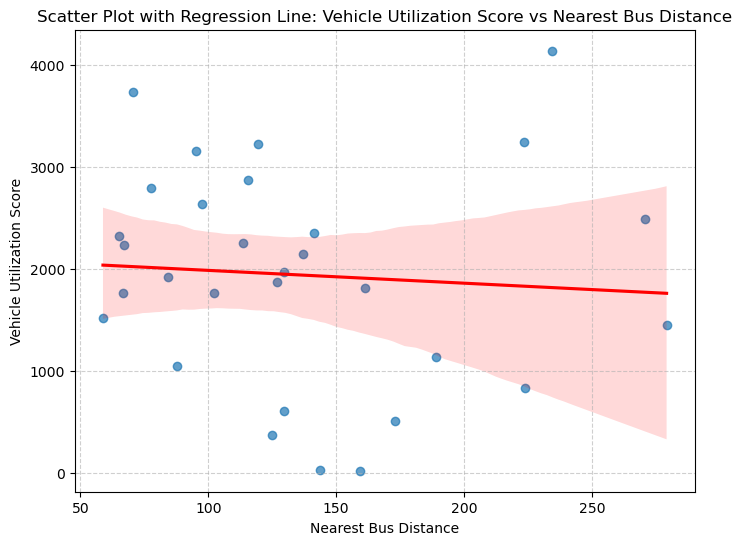

Correlation Coefficient: -0.07


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line: Vehicle Utilization Score vs Nearest Bus Distance
plt.figure(figsize=(8, 6))
sns.regplot(
    x='nearest_bus_distance',
    y='vehicle_utilization_score',
    data=joined_gdf,
    scatter_kws={'alpha': 0.7},  # Scatter style
    line_kws={'color': 'red'}  # Regression line style
)
plt.title('Scatter Plot with Regression Line: Vehicle Utilization Score vs Nearest Bus Distance')
plt.xlabel('Nearest Bus Distance')
plt.ylabel('Vehicle Utilization Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate and display the correlation coefficient
correlation_coefficient = joined_gdf['vehicle_utilization_score'].corr(joined_gdf['nearest_bus_distance'])
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")


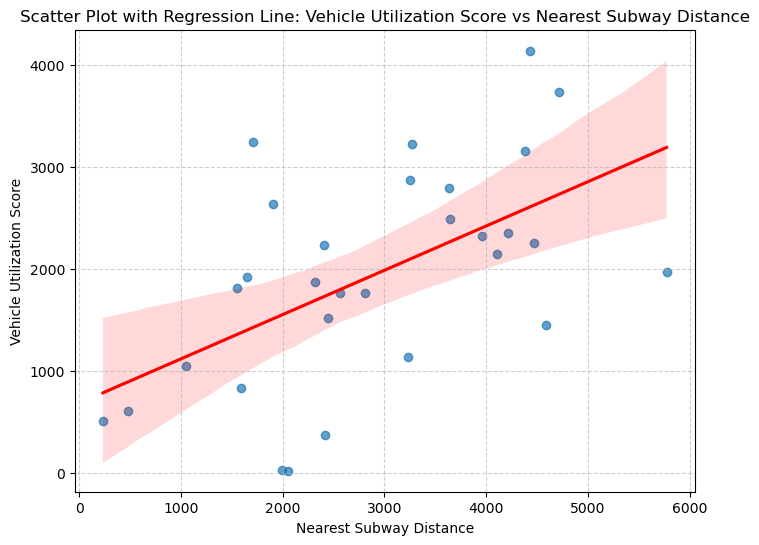

Correlation Coefficient: 0.56


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line: Vehicle Utilization Score vs Nearest Subway Distance
plt.figure(figsize=(8, 6))
sns.regplot(
    x='nearest_subway_distance',
    y='vehicle_utilization_score',
    data=joined_gdf,
    scatter_kws={'alpha': 0.7},  # Scatter style
    line_kws={'color': 'red'}  # Regression line style
)
plt.title('Scatter Plot with Regression Line: Vehicle Utilization Score vs Nearest Subway Distance')
plt.xlabel('Nearest Subway Distance')
plt.ylabel('Vehicle Utilization Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate and display the correlation coefficient
correlation_coefficient = joined_gdf['vehicle_utilization_score'].corr(joined_gdf['nearest_subway_distance'])
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")


##### 교통 네트워크 혼잡도

In [57]:
from shapely.geometry import LineString, MultiLineString

# Create a function to calculate congestion within a buffer
def calculate_congestion(buffer_geom, traffic_data):
    total_congestion = 0
    intersected_length = 0

    for line_geom, congestion in zip(traffic_data['geometry'], traffic_data['congestion']):
        if buffer_geom.intersects(line_geom):
            intersection = buffer_geom.intersection(line_geom)
            
            # Handle LineString case
            if isinstance(intersection, LineString):
                length = intersection.length
                total_congestion += congestion * length
                intersected_length += length
            
            # Handle MultiLineString case
            elif isinstance(intersection, MultiLineString):
                for sub_line in intersection.geoms:  # Use .geoms to iterate over components
                    length = sub_line.length
                    total_congestion += congestion * length
                    intersected_length += length

    # Avoid division by zero
    if intersected_length == 0:
        return 0

    return total_congestion / intersected_length

# Apply buffer and calculate congestion
joined_gdf['congestion'] = joined_gdf['geometry'].apply(
    lambda geom: calculate_congestion(geom.buffer(0.05), traffic_df)  # Adjust buffer size here
)

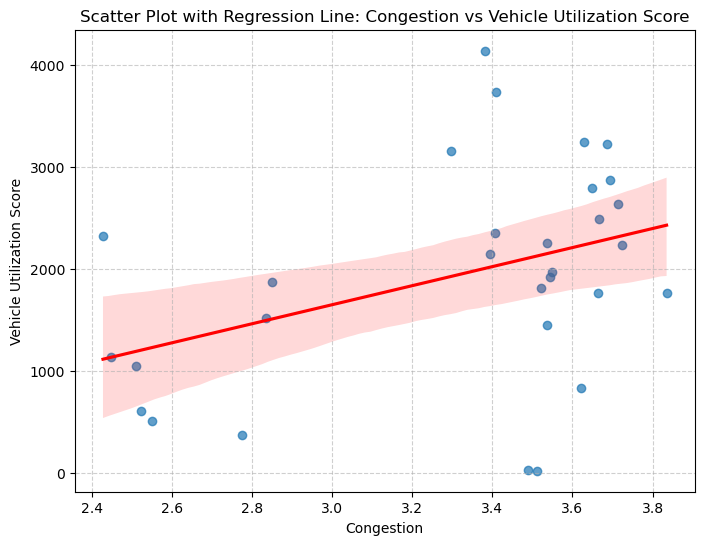

Correlation Coefficient: 0.40


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line: Congestion vs Vehicle Utilization Score
plt.figure(figsize=(8, 6))
sns.regplot(
    x='congestion',
    y='vehicle_utilization_score',
    data=joined_gdf,
    scatter_kws={'alpha': 0.7},  # Scatter style (e.g., transparency)
    line_kws={'color': 'red'}  # Regression line style
)
plt.title('Scatter Plot with Regression Line: Congestion vs Vehicle Utilization Score')
plt.xlabel('Congestion')
plt.ylabel('Vehicle Utilization Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate and display the correlation coefficient
correlation_coefficient = joined_gdf['congestion'].corr(joined_gdf['vehicle_utilization_score'])
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")

#### 모델 학습 준비

In [59]:
property3_df = joined_gdf[['blck_cd', 'type', 'noh', 'total_cnt', 'total_tm', 'car_cnt', 'vehicle_utilization_score', 'nearest_bus_distance','nearest_subway_distance', 'congestion']]

In [60]:
property3_df.to_csv('property3_df.csv', index=False)